## Problem Overview

In this notebook, we will find duplicate transactions in a credit card transaction dataset and build a fraud prediction model using the samples in the data.

## Import Modules

I am using anaoconda distribution (4.9.1) of python 3.7.1

List of sources of all modules: <br>
[pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html) <br>
[numpy](https://numpy.org/install/) <br>
[imblearn](https://imbalanced-learn.readthedocs.io/en/stable/install.html) <br>
[sklearn](https://scikit-learn.org/stable/install.html) <br>
[seaborn](https://seaborn.pydata.org/installing.html) <br>
[scikitplot](https://pypi.org/project/scikit-plot/) <br>
[matplotlib](https://pypi.org/project/matplotlib/) <br>
[datetime](https://pypi.org/project/DateTime/) <br>
[scipy](https://www.scipy.org/install.html)



In [368]:
#download and load the dataset
import urllib.request
import pandas as pd
import zipfile
import json

#calculation with matrices 
import numpy as np

#measure skewness of distribution
from scipy.stats import skew

#handle imbalanced dataset
from imblearn import under_sampling, over_sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#classification 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

#visualization
import seaborn as sns
import scikitplot as skplt
from matplotlib import pyplot as plt

import datetime
import warnings 
warnings.filterwarnings('ignore')

## Download Dataset (Question 1)

Lets first download the dataset as zipped file and unzip it.

In [369]:
#download dataset
urllib.request.urlretrieve('https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip', 'transactions.zip')

#unzip the data file
with zipfile.ZipFile('transactions.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Loading dataset into dataframe (Question 1)

In [370]:
#storing each dictionary as a list element
transactions = []

with open('transactions.txt') as fp:
    for line in fp:
        transactions.append(json.loads(line))

#converting list of dictionaries into dataframe
df = pd.DataFrame(transactions)

## Structure of the Data (Question 1)


First see first few rows in the dataset.

In [371]:
df.head()

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,737265056,2015-03-14,US,5000.0,414,1803,False,5000.0,0.0,06/2023,...,Uber,,,01,02,,,98.55,2016-08-13T14:27:32,PURCHASE
1,737265056,2015-03-14,US,5000.0,486,767,True,5000.0,0.0,02/2024,...,AMC #191138,,,01,09,,,74.51,2016-10-11T05:05:54,PURCHASE
2,737265056,2015-03-14,US,5000.0,486,767,False,5000.0,0.0,08/2025,...,Play Store,,,01,09,,,7.47,2016-11-08T09:18:39,PURCHASE
3,737265056,2015-03-14,US,5000.0,486,767,False,5000.0,0.0,08/2025,...,Play Store,,,01,09,,,7.47,2016-12-10T02:14:50,PURCHASE
4,830329091,2015-08-06,US,5000.0,885,3143,True,5000.0,0.0,10/2029,...,Tim Hortons #947751,,,01,02,,,71.18,2016-03-24T21:04:46,PURCHASE


In [372]:
#number of records and fields in the dataframe
df.shape

(786363, 29)

So there are **786,363** records and **29** fields in the dataset.

Lets take a look at the fields of the dataset.

In [373]:
list(df.columns)

['accountNumber',
 'accountOpenDate',
 'acqCountry',
 'availableMoney',
 'cardCVV',
 'cardLast4Digits',
 'cardPresent',
 'creditLimit',
 'currentBalance',
 'currentExpDate',
 'customerId',
 'dateOfLastAddressChange',
 'echoBuffer',
 'enteredCVV',
 'expirationDateKeyInMatch',
 'isFraud',
 'merchantCategoryCode',
 'merchantCity',
 'merchantCountryCode',
 'merchantName',
 'merchantState',
 'merchantZip',
 'posConditionCode',
 'posEntryMode',
 'posOnPremises',
 'recurringAuthInd',
 'transactionAmount',
 'transactionDateTime',
 'transactionType']

## Summary Statistics (Question 1)
Lets see a quick summary of the numerical fields in the data.

In [374]:
df.describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,10759.464459,4508.739089,136.985791
std,8880.783989,11636.174890,6457.442068,147.725569
min,-1005.630000,250.000000,0.000000,0.000000
25%,1077.420000,5000.000000,689.910000,33.650000
50%,3184.860000,7500.000000,2451.760000,87.900000
75%,7500.000000,15000.000000,5291.095000,191.480000
max,50000.000000,50000.000000,47498.810000,2011.540000


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [375]:
for col in df:
    print((col, df[col].nunique(), df[col].unique()))
    print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('accountOpenDate', 1820, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('cardCVV', 899, array(['414', '486', '885', '206', '579', '205', '640', '773', '483',
       '438', '808', '240', '736', '779', '853', '726', '142', '418',
       '310', '436', '557', '264', '402', '570', '307', '665', '781',
       '737', '692', '519', '717', '995', '311', '356', '197', '676',
       '647', '866', '461', '551', '529', '225', '671', '581', '963',
       '593', '215', '956', '655', '209', '128', '258', '788', '981',
       '236', '161', '151', '277', '965', '449', '930', '317', '798',
       '220', '296', '395', '822', 

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('dateOfLastAddressChange', 2184, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('echoBuffer', 1, array([''], dtype=object))

('enteredCVV', 976, array(['414', '486', '885', '206', '579', '539', '205', '265', '640',
       '670', '240', '630', '140', '679', '773', '173', '783', '713',
       '774', '483', '438', '433', '741', '808', '736', '779', '250',
       '440', '260', '746', '853', '726', '147', '418', '142', '172',
       '310', '436', '557', '264', '402', '202', '505', '570', '307',
       '470', '665', '781', '737', '337', '734', '692', '519', '717',
       '995', '311', '356', '350', '915', '197', '676', '647', '866',
       '461', '551', '555', '529', '329', '225', '255', '625', '671',
       '581', '963', '903', '593', '215', '956', '655', '209', '203',
       '269', '

('merchantCountryCode', 5, array(['US', 'CAN', '', 'PR', 'MEX'], dtype=object))

('merchantName', 2490, array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object))

('merchantState', 1, array([''], dtype=object))

('merchantZip', 1, array([''], dtype=object))

('posConditionCode', 4, array(['01', '08', '99', ''], dtype=object))

('posEntryMode', 6, array(['02', '09', '05', '80', '90', ''], dtype=object))

('posOnPremises', 1, array([''], dtype=object))

('recurringAuthInd', 1, array([''], dtype=object))

('transactionAmount', 66038, array([ 98.55,  74.51,   7.47, ..., 482.13, 451.71, 624.07]))

('transactionDateTime', 776637, array(['2016-08-13T14:27:32', '2016-10-11T05:05:54',
       '2016-11-08T09:18:39', ..., '2016-12-27T15:46:24',
       '2016-12-29T00:30:55', '2016-12-30T20:10:29'], dtype=object))

('transactionType', 4, array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object))



From above information, I'll now briefly describe the fields of the data to summarize domain knowledge:

### Categorical fields:

**accountNumber** : Account number of the account where transaction was made from. The dataset contains transaction from 5000 accounts.

**accountOpenDate** : Date when the account was opened.

**acqCountry** : Country where the credit card is acquired. There is 5 unique values for this field. <br>

**cardCVV** : CVV is the three digit number on credit card that adds an extra layer of security when making purchases online or over the phone. <br>

**cardLast4Digits** : Last 4 digits of the credit card.

**currentExpDate** : Expiry date of the card.

**customerID** : ID of the customer making the transaction. The dataset contains transaction of 5000 customers.

**dateOfLastAddressChange** : The date the account holder last changed his/her address.

**enteredCVV** : CVV entered by the customer during the transaction.

**expirationDateKeyInMatch** : If the expired date entered by the customer matched with original. This is a boolean field.

**isFraud** : If the transaction was found to be fraud or not. This is a boolean field.

**merchantCategoryCode** : Category of the merchant that was selling the product/service. There are 19 unique categories.<br>

**merchantCity** : City the merchant located in.

**merchantCountryCode** : Code of the county the merchant located in. It can take 5 different values.

**merchantName** : Name of the merchant/seller. The data shows transactions with 2490 merchants.

**posConditionCode** : This field contains a code identifying transaction conditions at the point-of-sale or point-of-service. 4 unique values available.

**posEntryMode** : This two-digit code identifies the actual method used to enter the cardholder account number and card expiration date. 6 unique values available.

**transactionDateTime** : Time when the transaction took place.

**transactionType** : Category the transaction falls into. 4 different types available.


### Numerical fields:

**creditLimit** : Credit limit in the account. It can take 10 different values.

**availableMoney** : Amount of money available in the account.

**currentBalance** : Total amount of due/balance in the credit card.

**transactionAmount** : Amount of the transaction in dollars.

Lets now count **null/empty values** for each field.

In [376]:
for col in df:
    
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: 
        
        #for categorical data type
        print(col, df[df[col] == ''].shape[0])
    
    elif df[col].isna().sum() > 0:
        #for numerical data type
        print(col, df[col].isna().sum())

acqCountry 4562
echoBuffer 786363
merchantCity 786363
merchantCountryCode 724
merchantState 786363
merchantZip 786363
posConditionCode 409
posEntryMode 4054
posOnPremises 786363
recurringAuthInd 786363
transactionType 698


## Histogram of the Processed Amounts of Each Transaction (Question 2)

Let's plot a histogram of the transaction amounts and see what the distribution looks like.

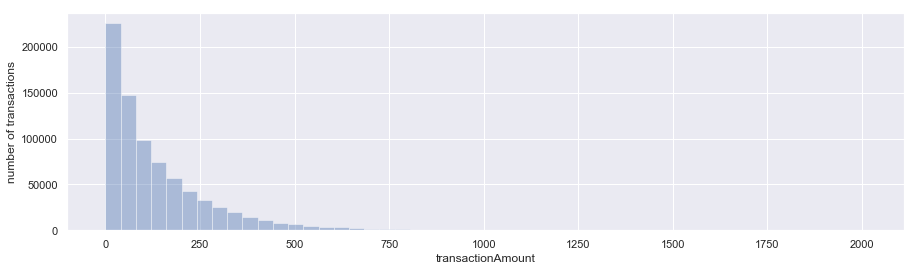

In [377]:
sns.distplot(df['transactionAmount'] , hist = True, kde = False)
plt.ylabel('number of transactions', fontsize=12)
plt.show()

In [378]:
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['transactionAmount']) ))

skewness of normal distribution (should be 0): 2.0922422738206343


From both the plot and skewness ( > 0) it's clear that the distribution of transactions is **right skewed**, that means
   * It is not symmetric around the mean.
   * The mean is greater than the median. 
   * The tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is - **credit card usage is mostly popular for small transactions**.

## Duplicate Transactions (Question 3)

In my opinion **accountNumber**, **merchantName**, **transactionType**, **transactionAmount** and **transactionDateTime** are the necessary fields to identify duplicate transacations. I'll first create a dataframe selecting these fields only.

In [379]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]

### Reversed Transaction Duplicates

First find the total count of duplicates that resulted from **reversed transactions**. These duplicate happens when a purchase is followed by a reversal.

The idea is as follows:
 * Split the dataframe in two parts based on the transaction type, one for **PURCHASE** and another for **REVERSAL**.
 * I assumed for every reversal transaction, there exists **at most one** corresponding purchase transaction. There can be reversal purchase record in the dataset that does not have any any matching purchase transaction.
 * I assumed a purchase transaction that occured earlier than a reversal purchase having same *account name*, *merchant name* and *transaction amount* is basically a duplicate of the reversal purchase.
 * For each reversal transaction, I checked what purchase transaction exists that has the same *account name*, *transaction amount* and *merchant name* as the reversal transaction, but happened in an earlier time. I did not set a threshold for time gap here, because sometimes merchants refund a customer even several months after the purchase depending on their policy.
 

In [382]:
#create two dataframes for two types of transaction
dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'REVERSAL']

#count of number of duplicates and total amount 
totalReversedDuplicates = 0
totalReversedDuplicatesAmount = 0

dfPurchaseSameAccount = None
prevAccountNumber = None

for _, row in dfReversal.iterrows():
    
    #extracting transactions from the purchase dataframe with the account same account number as the reversal transaction
    #to save computation time. As account numbers grouped together in the dataframes, if I encounter a transaction from the
    #same account during the iteration, I don't have to repeat the extraction step.
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
        
    #checking if there exists any purchase transaction with the same account name, merchant name and transaction amount
    #as the reversal transaction, where the purchase took place earlier 
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & 
        (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & 
        (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        
        totalReversedDuplicates += 1
        totalReversedDuplicatesAmount += row['transactionAmount']

print('Total number of reversal duplicates: ', totalReversedDuplicates)
print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)
print('Mean amount of reversal duplicates: $', totalReversedDuplicatesAmount/totalReversedDuplicates)

Total number of reversal duplicates:  17759
Total dollar amount of reversal duplicates: $ 2666519.26999999
Mean amount of reversal duplicates: $ 150.15030519736413


### Multiple Swipes Duplicates

Now let's find the duplicates resulted from multiple swipes of the credit card. These duplicates happen when a vendor accidentally charges a customer's card multiple times within a short time span.

The idea is as follows:
 * I analyzed the dataset and found that transactions are grouped by account number in the dataset. Also a group of transactions having same account number are ordered by increasing time stamp.
 * If a purchase transaction occurs within a specific time of another purchase transaction with same account number, merchant name and transaction amount, I will consider them as duplicates.
 * I am assuming all multiple swipes occurs within a duration of **2 minutes (= 120 seconds)**. Thus if a purchase meets all specification of multiple swipes but occurs within a time difference more than 2 minutes I will consider it a valid transaction. The rationale behind this 2 minute assumption is multiple swipes practically occur within a short period of time.
 * For a purchase transaction, there can exist any number (including zero) of multiple swipes in the dataset.
 * For each purchase transaction, I iterated over the next purchase transactions for the same account number that occured within 2 minutes. If any of those purchase has same account number, merchant number and transaction amount I will count it as a duplicate.
 * I excluded the first transaction from the set of duplicate transaction. The first one is considered valid transaction, while rest will be treated as duplicates.
 


In [385]:
#assigning new index to the purchase transaction dataframe because we will iterate over index here
dfPurchase = dfPurchase.reset_index(drop=True)

#count of number of duplicates and total amount
totalMultiSwipeDuplicates = 0
totalMultiSwipeDuplicatesAmount = 0

lastSeenDuplicateTransaction = -1

#this outer loop selects a valid transaction
for index1, row in dfPurchase.iterrows():
        
    if index1 < lastSeenDuplicateTransaction:
        continue
        
    #this inner loops selects a duplicate transaction     
    for index2 in range(index1+1, dfPurchase.shape[0]):
        
        #if encounter a transaction with different account number, we don't need to search any further
        if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
            break
            
        t1 = pd.to_datetime(row['transactionDateTime'])
        t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
        #checking if the valid transaction and its candidate duplicate occured within a specific timeframe
        if pd.Timedelta(t2 - t1).seconds > 120:
            break
        
        #if merchant name and transaction name matches with valid transaction, then a duplicate is found
        if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
            totalMultiSwipeDuplicates += 1
            totalMultiSwipeDuplicatesAmount += row['transactionAmount']
            lastSeenDuplicateTransaction = index2    

print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)
print('Mean amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount/totalMultiSwipeDuplicates)

Total number of multiple swipes duplicates:  4941
Total dollar amount of multiple swipes duplicates: $ 744621.5799999982
Mean amount of multiple swipes duplicates: $ 150.70260675976488


Some interesting observation about the duplicate transactions:

* Five fields in the dataset were particularly important to identify both types of duplicate transactions
    * accountNumber
    * merchantName
    * transactionType
    * transactionAmount
    * transactionDateTime
    
    
* Number of duplicates by multiple swipes increases if time gap is made more flexible. Fixing a time gap threshold needs proper  domain knowledge about credit card transaction and real life observation of such occurrences.


* While the mean transaction amount for both type of duplicates (reversed and multiple swipe) is equal (\\$150), it is much higher than mean of all transaction amount (\\$136). It is possible that the duplicate transactions comes from a different distribution than the regular transaction.

## Predictive Model (Question 4)

I will now show how to build a predictive model to detect fraudulent transactions. This is a classification problem where dependent variable is **isFraud**. Being a boolean type categorical variable, it can take two values ['True', 'False']. These are the class labels.

Let's quickly check the mean value for the numeric and boolean features in the dataset for both class labels.

In [386]:
df.groupby('isFraud').mean()

,availableMoney,cardPresent,creditLimit,currentBalance,expirationDateKeyInMatch,transactionAmount
isFraud,,,,,,
False,6252.455386,0.451469,10754.884062,4502.428675,0.001331,135.570249
True,6142.894186,0.278248,11044.958525,4902.064338,0.001047,225.215905


From our observation we can see these features has important role to play in classifying a transaction as fraud or not, as their mean differs for both classes to some extent. For example, **transactionAmount** appears to be a valuable feature due to its mean pretty much different for fraudulent (225.2) and non-fraudulent class (135.6).

### Data preprocessing

Lets find the fields that has constant (same) values in all rows.

In [289]:
nunique = df.apply(pd.Series.nunique)
constantColumnNames = nunique[nunique == 1].index
constantColumnNames

Index(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip',
       'posOnPremises', 'recurringAuthInd'],
      dtype='object')

Now drop these fields from the dataframe.

In [290]:
df.drop(columns=constantColumnNames, axis=1, inplace=True)

If there are fields that are duplicates (another column exists with same value for each row), we should remove one of the duplicate columns. Below we found that **customerId** is a duplicate field.

In [291]:
duplicateColumnNames = set()
# Iterate over all the columns in dataframe
for x in range(df.shape[1]):
    # Select column at xth index.
    col = df.iloc[:, x]
    # Iterate over all the columns in DataFrame from (x+1)th index till end
    for y in range(x + 1, df.shape[1]):
        # Select column at yth index.
        otherCol = df.iloc[:, y]
        # Check if two columns at x 7 y index are equal
        if col.equals(otherCol):
            duplicateColumnNames.add(df.columns.values[y])
duplicateColumnNames = list(duplicateColumnNames)
duplicateColumnNames

['customerId']

Lets drop **customerId** field

In [292]:
df.drop(columns=duplicateColumnNames, axis=1, inplace=True)

Adding a new field **CVVmatched** that shows if entered CVV matched with original CVV

In [293]:
df['CVVmatched'] = df['enteredCVV'] == df['cardCVV']

Adding a new field **accountAge** that shows how long ago (in seconds) the account was opened until the transaction

In [294]:
df['accountAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['accountOpenDate'])
df['accountAge'] = df['accountAge'].dt.total_seconds()

Adding a new field **addressAge** that shows what how long (in seconds) the cardholder has been living in his last address until the transaction 

In [295]:
df['addressAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['dateOfLastAddressChange'])
df['addressAge'] = df['addressAge'].dt.total_seconds()

Adding new column **isMerchantCountryCode**

In [296]:
# def label_race (row):
#     if row['merchantCountryCode'] == '' :
#         return False
#     else:
#         return True
# #df.apply (lambda row: label_race(row), axis=1)
# df['isMerchantCountryCode'] = df.apply (lambda row: label_race(row), axis=1)

In [297]:
# def label_race (row):
#     if row['posConditionCode'] == '' :
#         return False
#     else:
#         return True
# #df.apply (lambda row: label_race(row), axis=1)
# df['isPosConditionCode'] = df.apply (lambda row: label_race(row), axis=1)

In [298]:
# def label_race (row):
#     if row['posEntryMode'] == '' :
#         return False
#     else:
#         return True
# #df.apply (lambda row: label_race(row), axis=1)
# df['isPosEntryMode'] = df.apply (lambda row: label_race(row), axis=1)

In [299]:
# def label_race (row):
#     if row['merchantCategoryCode'] in ['rideshare', 'online_retail', 'online_gifts', 'airline']:
#         return True
# #     elif row['merchantCategoryCode'] in ['entertainment', 'fastfood', 'auto', 'food', 'furniture', 'subscriptions']:
# #         return 'Medium'
#     else:
#         return False
# #df.apply (lambda row: label_race(row), axis=1)
# df['merchantCategoryRisk'] = df.apply (lambda row: label_race(row), axis=1)

In [300]:
# def label_race (row):
#     if row['transactionType'] == 'ADDRESS_VERIFICATION' :
#         return False
#     else:
#         return True
# #df.apply (lambda row: label_race(row), axis=1)
# df['isTransactionType'] = df.apply (lambda row: label_race(row), axis=1)

### Feature Selection

From the correlation matrix below we see **creditLimit** and **availableMoney** are highly correlated.

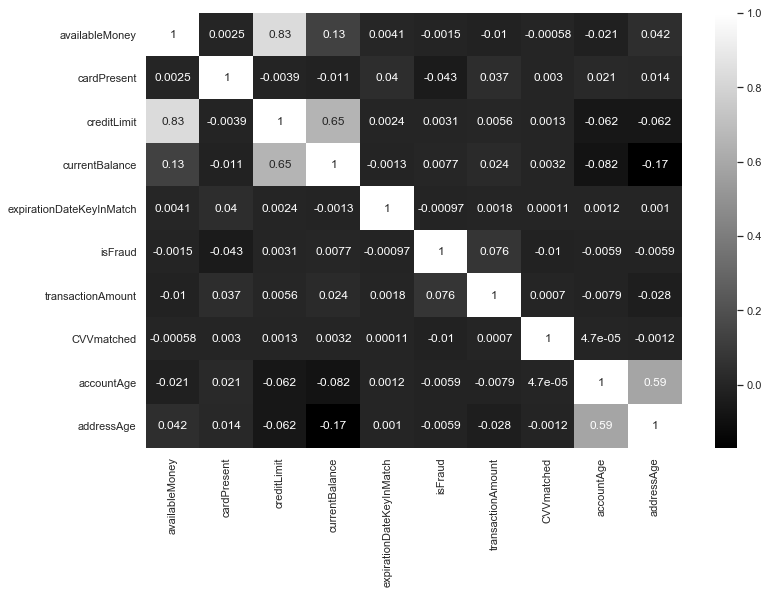

In [301]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="gist_gray")
plt.show()

Features **creditLimit** and **availableMoney** are highly correlated (ρ = 0.834977). I will drop **creditLimit**.

In [302]:
df.drop(columns=['creditLimit'], axis=1, inplace=True)

For transactions with empty ('') **merchantCountryCode** value , below we see there is a higher ratio for a them being fraud.

Now lets remove unimportant categorical fields.

In [303]:
df.drop(columns=['currentExpDate','merchantName', 'accountOpenDate',  'cardLast4Digits',  'dateOfLastAddressChange', 'transactionDateTime', 'accountNumber', 'cardCVV', 'enteredCVV'], axis=1, inplace=True)

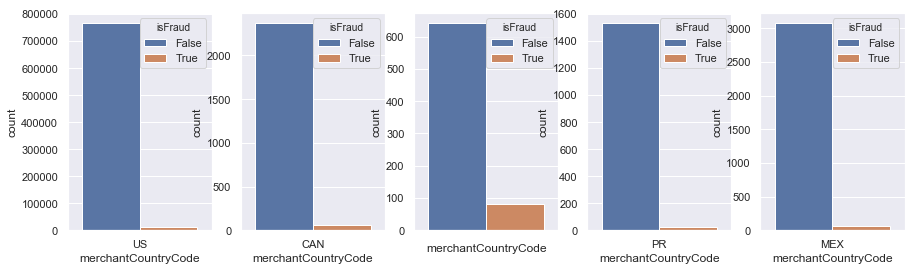

In [304]:
fig, ax = plt.subplots(1, 5)
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df['merchantCountryCode'].unique()):
    sns.countplot(x='merchantCountryCode', hue='isFraud', data=df[df['merchantCountryCode']== value], ax=ax[index])
fig.show()

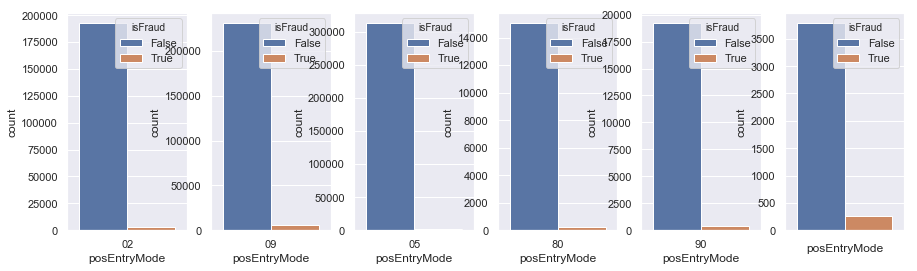

In [305]:
col = 'posEntryMode'

fig, ax = plt.subplots(1, df[col].nunique())
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df[col].unique()):
    sns.countplot(x=col, hue='isFraud', data=df[df[col]== value], ax=ax[index])
fig.show()

In [306]:
print(df.columns)

Index(['acqCountry', 'availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCountryCode', 'posConditionCode', 'posEntryMode',
       'transactionAmount', 'transactionType', 'CVVmatched', 'accountAge',
       'addressAge'],
      dtype='object')


In [323]:
df_temp = df
dum_df = pd.get_dummies(df_temp, columns=['acqCountry', 'transactionType', 'posConditionCode' , 'merchantCategoryCode', 'merchantCountryCode', 'posEntryMode' ])
df_temp = dum_df

In [324]:
y = df_temp[['isFraud']]
X = df_temp.drop(columns=['isFraud' ], axis=1)

X.columns

Index(['availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'transactionAmount', 'CVVmatched',
       'accountAge', 'addressAge', 'acqCountry_', 'acqCountry_CAN',
       'acqCountry_MEX', 'acqCountry_PR', 'acqCountry_US', 'transactionType_',
       'transactionType_ADDRESS_VERIFICATION', 'transactionType_PURCHASE',
       'transactionType_REVERSAL', 'posConditionCode_', 'posConditionCode_01',
       'posConditionCode_08', 'posConditionCode_99',
       'merchantCategoryCode_airline', 'merchantCategoryCode_auto',
       'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
       'merchantCategoryCode_online_gifts',
  

In [325]:
from sklearn.feature_selection import RFE
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X, y.values.ravel())

dfBool = pd.Series(rfe.support_)
X = X[X.columns[dfBool]]

In [326]:
X.columns

Index(['availableMoney', 'cardPresent', 'currentBalance', 'transactionAmount',
       'CVVmatched', 'accountAge', 'addressAge', 'acqCountry_US',
       'transactionType_PURCHASE', 'posConditionCode_01',
       'posConditionCode_08', 'merchantCategoryCode_entertainment',
       'merchantCategoryCode_fastfood', 'merchantCategoryCode_food',
       'merchantCategoryCode_online_retail', 'merchantCategoryCode_rideshare',
       'merchantCountryCode_US', 'posEntryMode_02', 'posEntryMode_05',
       'posEntryMode_09'],
      dtype='object')

### Class Imbalance

From the plot below it's clear that the dataset is **highly imbalanced**.

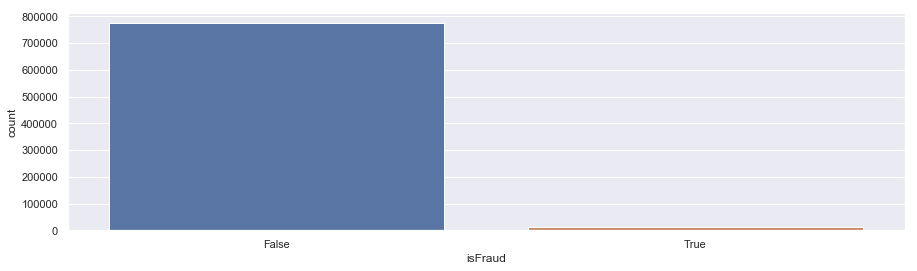

In [327]:
sns.countplot(x='isFraud', data = df)
plt.show()

Lets first scale the value of data.

In [328]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

We will now re-sample the dataset to get a balanced training data.

In [329]:
def resampling(X, y):
    # define pipeline
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    #X, y = pipeline.fit_resample(X, y)
    return pipeline.fit_resample(X, y)

### Logistic Regression Model

In [330]:
def model(X_train, X_test, y_train, y_test):
    

    start = time.time()
    clf = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced',
                                          tol=1e-3, max_iter=1000000,
                                          warm_start=True, random_state=42,
                                          intercept_scaling=1000)

    clf.fit(X_train , np.ravel(y_train))

    return clf.predict(X_test)
    

### Validation

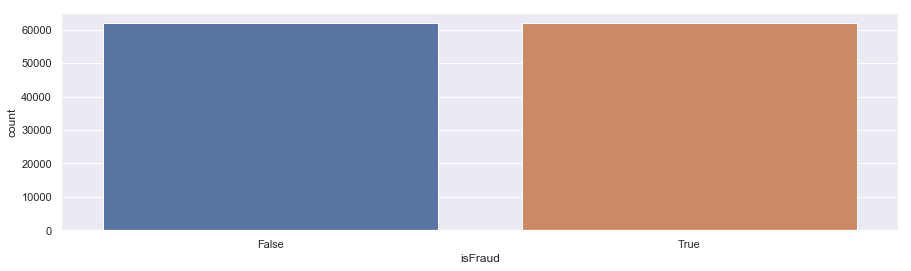

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = resampling(X_train, y_train)

sns.countplot(x='isFraud', data = X_train.join(y_train))
plt.show()

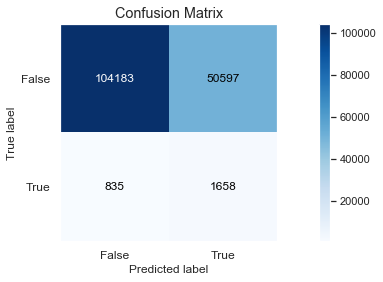

In [332]:
predict =  model(X_train, X_test, y_train, y_test)

skplt.metrics.plot_confusion_matrix(y_test, predict)

In [333]:
print(accuracy_score(y_test, predict))

0.6729762896364919


### ROC Curve

Text(0.5, 0, 'False positive rate')

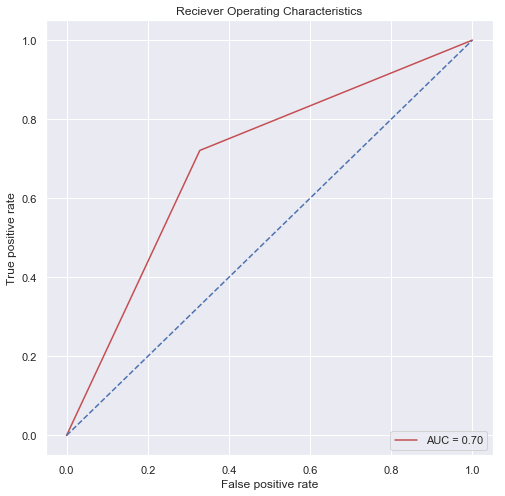

In [336]:
frp,trp, threshold = roc_curve(y_test, predict)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(8,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### K-fold Cross Validation

In [335]:
kf = KFold(n_splits=10)
auc_scores = []

k = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    
    X_train, y_train = resampling(X_train, y_train)
    predict = model(X_train, X_test, y_train, y_test)
    
    auc_score = roc_auc_score(y_test, predict)
    print('AUC score for fold #'+str(k)+' : ', auc_score)
    auc_scores.append(auc_score)
    k+= 1

print("Mean AUC score: ", sum(auc_scores)/len(auc_scores))

AUC score for fold #1 :  0.6230626093513979
AUC score for fold #2 :  0.6724867157260606
AUC score for fold #3 :  0.7058708874086127
AUC score for fold #4 :  0.6986235582943434
AUC score for fold #5 :  0.6793178888831126
AUC score for fold #6 :  0.6992436602606968
AUC score for fold #7 :  0.6365941600825259
AUC score for fold #8 :  0.6812533754794003
AUC score for fold #9 :  0.5915920036741356
AUC score for fold #10 :  0.6963026698365048
Mean AUC score:  0.6684347528996789
